In [1]:
import os

import causaldag as cd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import wandb

api = wandb.Api()
coder_name = input('Please input the coder name')  # For anonymity

In [2]:
GOOD = '2220qk1w'
BAD = '2u6twggf'

SIDES = [
    (GOOD, 'L'),  # example of good prediction
    (BAD, 'R')   # example of bad prediction
]

TRUE_DAGS = {
    GOOD: '010_SF2_gaussian_ev_2022-08-20_BST_11:39:28,507_create_dags',
    BAD: '010_ER4_gaussian_ev_2022-08-20_BST_11:38:06,145_create_dags'
}
LOGS = {
    GOOD: '2022-09-05_BST_12:52:07,099_look_imle_l_none',
    BAD: '2022-09-05_BST_13:36:39,171_look_imle_l_none'
}
STEEPNESS = {
    GOOD: 4,
    BAD: 1

}
FIGS = {
    GOOD: 'good-diag',
    BAD: 'bad-diag'
}

# figure size in inches
rcParams['figure.figsize'] = 5.5, 4

SHOW_PLOTS = False

def show():
    if SHOW_PLOTS:
        plt.show()

In [4]:
for run_name, side in SIDES:
    run = api.run(coder_name + '_ucl/Thetas/' + run_name)
    h = run.history()
    h = h.rename(columns={column: column[:-3] for column in h.columns})
    h = h.rename(columns={
        't_loss': 't_MSE', 'v_loss': 'v_MSE', '_s': 'epoch',
        'nshd_c': 'nSHD_c', 'change_adj_count': 'change_Z_count',
        't_theta_adj': 'mean_theta_adj',
        'v_theta_adj': 'MAP_theta_adj',
        't_theta_non_adj': 'mean_theta_non_adj',
        'v_theta_non_adj': 'MAP_theta_non_adj'
    })
    h = h.set_index('epoch')

    print('\n', run_name)
    print(h.iloc[-1][['nSHD_c', 'prec_c', 'size']])

    plot_1 = ['t_MSE', 'v_MSE']
    s = sns.lineplot(data=h[plot_1])
    show()
    plt.savefig(f'wandb_{side}1.pdf')
    plt.clf()
    plot_2 = [
        'mean_theta_adj', 'MAP_theta_adj',
        'mean_theta_non_adj', 'MAP_theta_non_adj'
    ]
    sns.lineplot(data=h[plot_2])
    show()
    plt.savefig(f'wandb_{side}2.pdf')
    plt.clf()
    plot_3 = ['change_Z_count', 'size']
    sns.lineplot(data=h[plot_3])
    show()
    plt.savefig(f'wandb_{side}3.pdf')
    plt.clf()
    plot_4 = ['nSHD_c', 'prec_c']
    sns.lineplot(data=h[plot_4])
    show()
    plt.savefig(f'wandb_{side}4.pdf')
    plt.clf();


 2220qk1w
nSHD_c     0.200000
prec_c     0.941176
size      17.000000
Name: 999, dtype: float64

 2u6twggf
nSHD_c     2.900000
prec_c     0.538462
size      26.000000
Name: 995, dtype: float64


<Figure size 396x288 with 0 Axes>

## Draw predictions

In [4]:
def get_graphs(key):
    adj_true_file = os.path.join(
        '..', '..', '..', 'logs', LOGS[key] + '_adj_true.ods')
    adj_true = pd.read_excel(
        adj_true_file, index_col=0, engine='odf').to_numpy()
    g_true = nx.DiGraph(adj_true)

    adj_pred_file = os.path.join(
        '..', '..', '..', 'logs', LOGS[key] + '_adj_pred.ods')
    adj_pred = pd.read_excel(
        adj_pred_file, index_col=0, engine='odf').to_numpy()
    g_pred = nx.DiGraph(adj_pred)

    return g_true, g_pred


def get_cpdag(g):
    return nx.DiGraph(cd.DAG.from_nx(g).cpdag().to_amat()[0])


def get_tg(g):
    tg = [(idx, np.sort(gen))
           for idx, gen in enumerate(nx.topological_generations(g))]
    return tg


def draw_dag(g, cpdag=None, tg_idx=None, steepness=2,
             edgelist=None, edge_color='k', arrow_style='->', file_title=None):
    if tg_idx is None:
        tg = get_tg(g)
        tg_idx = dict()
        for idx, gen in tg:
            for y, node in enumerate(gen):
                if file_title == 'bad-diag':
                    if idx < 5:
                        x_pos = idx * 2
                    else:
                        x_pos = 18 - 2 * idx
                    tg_idx[node] = (x_pos, y + idx ** steepness / 20)
                else:
                    tg_idx[node] = (idx, y + idx ** steepness / 20)
    g = g if cpdag is None else cpdag
    if edgelist is None:
        nx.draw_networkx(
            g,
            pos=tg_idx,
            node_size=1200, font_size=20, font_color='k'
		)
    else:
        fig = plt.figure(figsize = (20, 15))
        nx.draw_networkx(
            g,
            pos=tg_idx,
            node_size=1200, font_size=20, font_color='w', width=2,
            edgelist=edgelist, edge_color=edge_color, node_color='k',
            ax=fig.add_subplot(111)
        )
        fig.savefig(f'{file_title}.pdf')
    return tg_idx


def draw_dags(key, g_true, g_pred, cpdags=False, pred_with_true_pos=False):
    if cpdags:
        cpdag_true = get_cpdag(g_true)
        cpdag_pred = get_cpdag(g_pred)
    else:
        cpdag_true = cpdag_pred = None
    fig = plt.figure(figsize = (20, 15))
    ax = fig.add_subplot(2, 1, 1)
    ax.set_title('g_true')
    true_tg_idx = draw_dag(g_true, cpdag=cpdag_true, steepness=STEEPNESS[key])
    ax = fig.add_subplot(2, 1, 2)
    if pred_with_true_pos:
        ax.set_title('g_pred (true node positions)')
    else:
        ax.set_title('g_pred')
    tg_idx = true_tg_idx if pred_with_true_pos else None
    draw_dag(g_pred, cpdag=cpdag_pred,
             tg_idx=tg_idx,
             steepness=STEEPNESS[key])


def get_edge_tuples(edges_fs):
    edges = set()
    for edge in edges_fs:
        edge_tuple = tuple(edge)
        edge_tuple_rev = (edge_tuple[1], edge_tuple[0])
        edges |= {edge_tuple, edge_tuple_rev}
    return edges


def draw_cpdags_in_one(key, g_true, g_pred):
    cpdag_true = cd.DAG.from_nx(g_true).cpdag()
    cpdag_pred = cd.DAG.from_nx(g_pred).cpdag()

    edges_true = get_edge_tuples(cpdag_true.edges)
    arcs_true = cpdag_true.arcs
    edges_pred = get_edge_tuples(cpdag_pred.edges)
    arcs_pred = cpdag_pred.arcs

    edges_missed =  edges_true - edges_pred
    # red = {tuple(edge) for edge in edges_missed }
    edges_extra =  edges_pred - edges_true
    edges_correct = edges_pred.intersection(edges_true)
    # black = edges_correct
    arcs_missed =  arcs_true - arcs_pred
    # red = red | arcs_missed
    arcs_extra =  arcs_pred - arcs_true
    # green = green | arcs_extra
    # print(f'{len(green) - len(edges_extra)=}\n')
    arcs_correct = arcs_pred.intersection(arcs_true)
    # black = black | arcs_correct
    print(f'{len(arcs_missed) + (len(edges_missed) // 2) =}')
    print(f'{len(arcs_extra) + (len(edges_extra) // 2) =}')
    # print(
    #     f'{len(arcs_extra.intersection(edges_missed) + len(arcs_missed | edges_extra)=}')
    # print(f'{len(arcs_missed)=}')
    # print(f'{len(arcs_extra)=}')
    # print(f'{(len(edges_missed) // 2) =}')
    # print(f'{(len(edges_extra) // 2) =}')

    edges = [
        *[(edge, 'b', '-') for edge in edges_extra],
        *[(edge, 'r', '-') for edge in edges_missed],
        *[(edge, 'k', '-') for edge in edges_correct],
        *[(arc, 'b', '->') for arc in arcs_extra],
        *[(arc, 'r', '->') for arc in arcs_missed],
        *[(arc, 'k', '->') for arc in arcs_correct],
    ]
    edgelist, edge_color, arrow_style = list(zip(*edges))
    # edges = edge_color.keys()
    nodes = g_true.nodes

    # edge_color = {
    #     **{edge: 'k' for edge in black},
    #     **{edge: 'r' for edge in red},
    #     **{edge: 'g' for edge in green},
    # }
    # edgelist = edges
    # edge_color = edge_color.values()
    g = nx.DiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edgelist)
    draw_dag(
        g_true, cpdag=g, steepness=STEEPNESS[key],
        edgelist=edgelist, edge_color=edge_color, arrow_style=arrow_style,
        file_title=FIGS[key]
    )


len(arcs_missed) + (len(edges_missed) // 2) =1
len(arcs_extra) + (len(edges_extra) // 2) =1
len(arcs_missed) + (len(edges_missed) // 2) =28
len(arcs_extra) + (len(edges_extra) // 2) =12


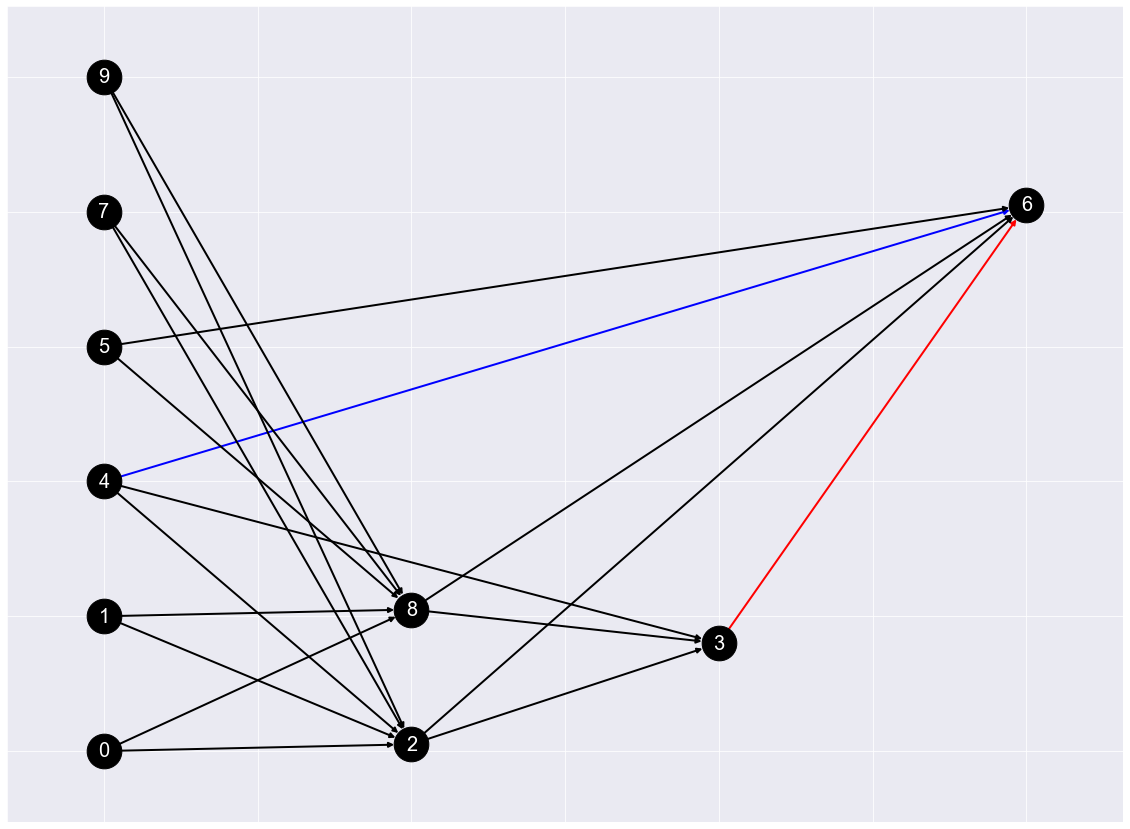

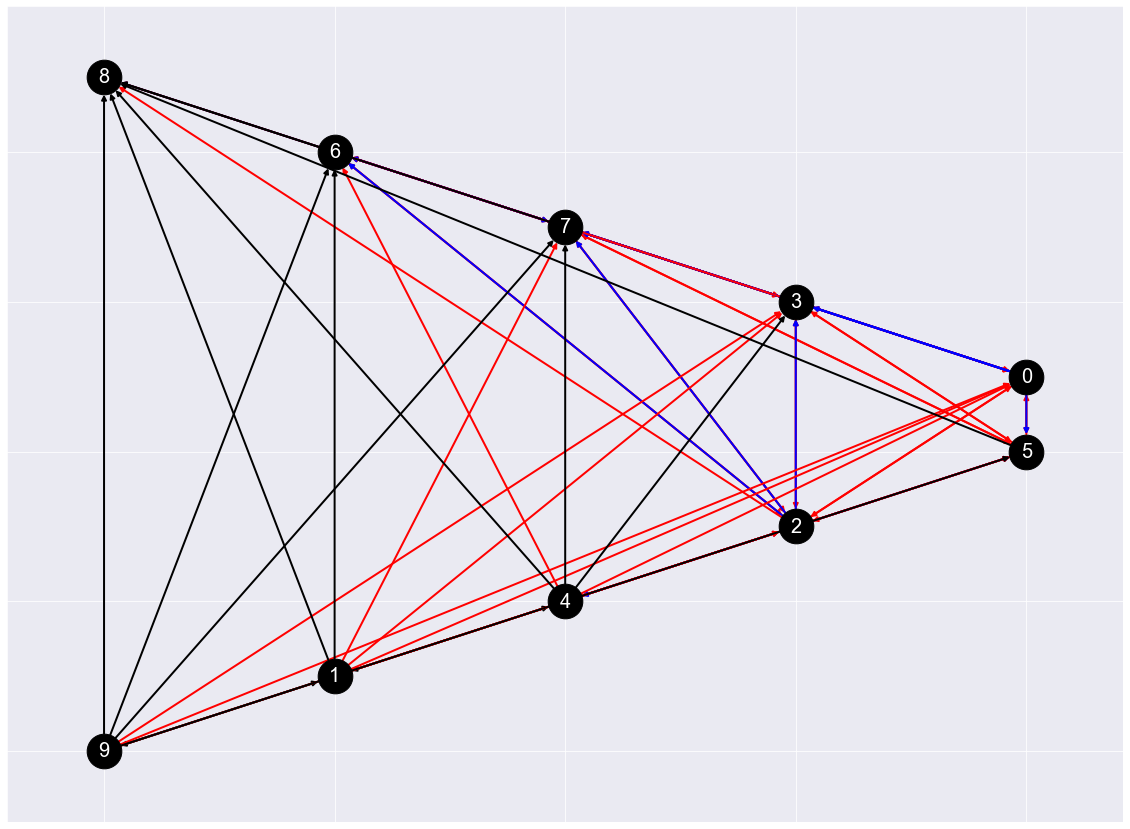

In [5]:
for key in LOGS:
    g_true, g_pred = get_graphs(key)
    draw_cpdags_in_one(key, g_true, g_pred)


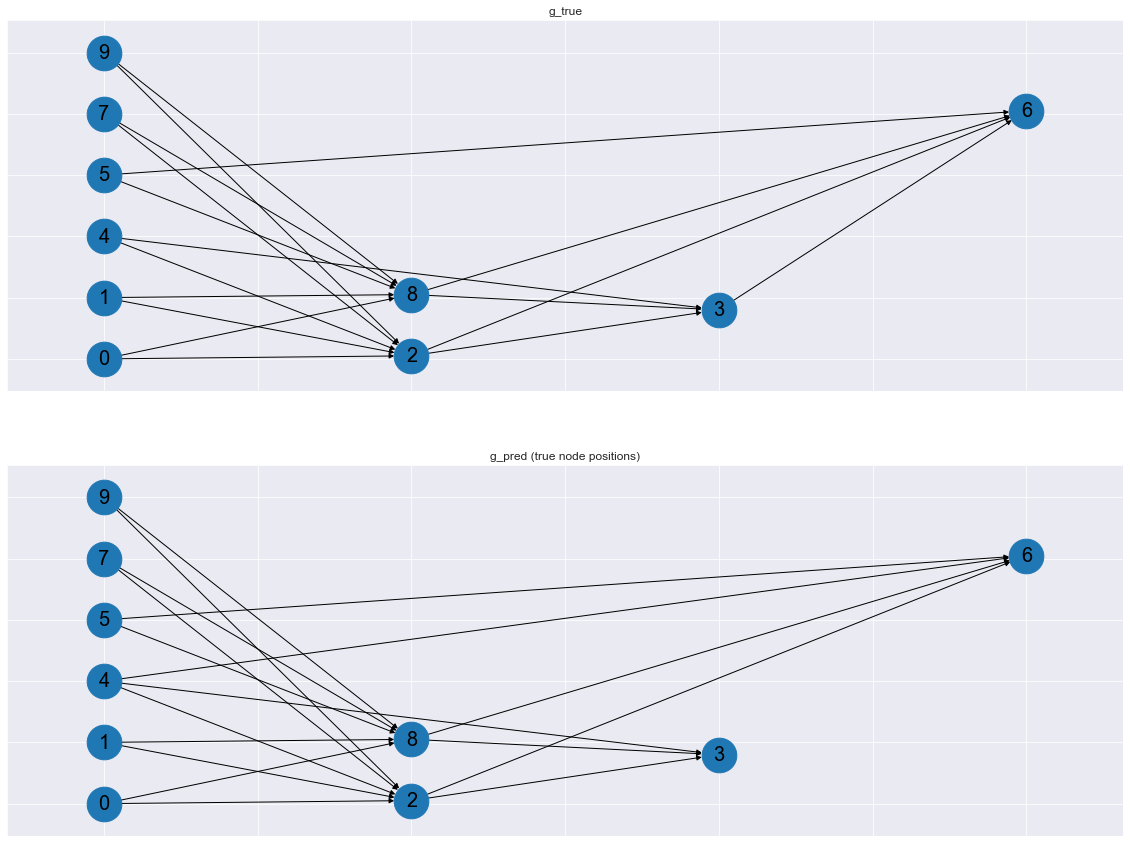

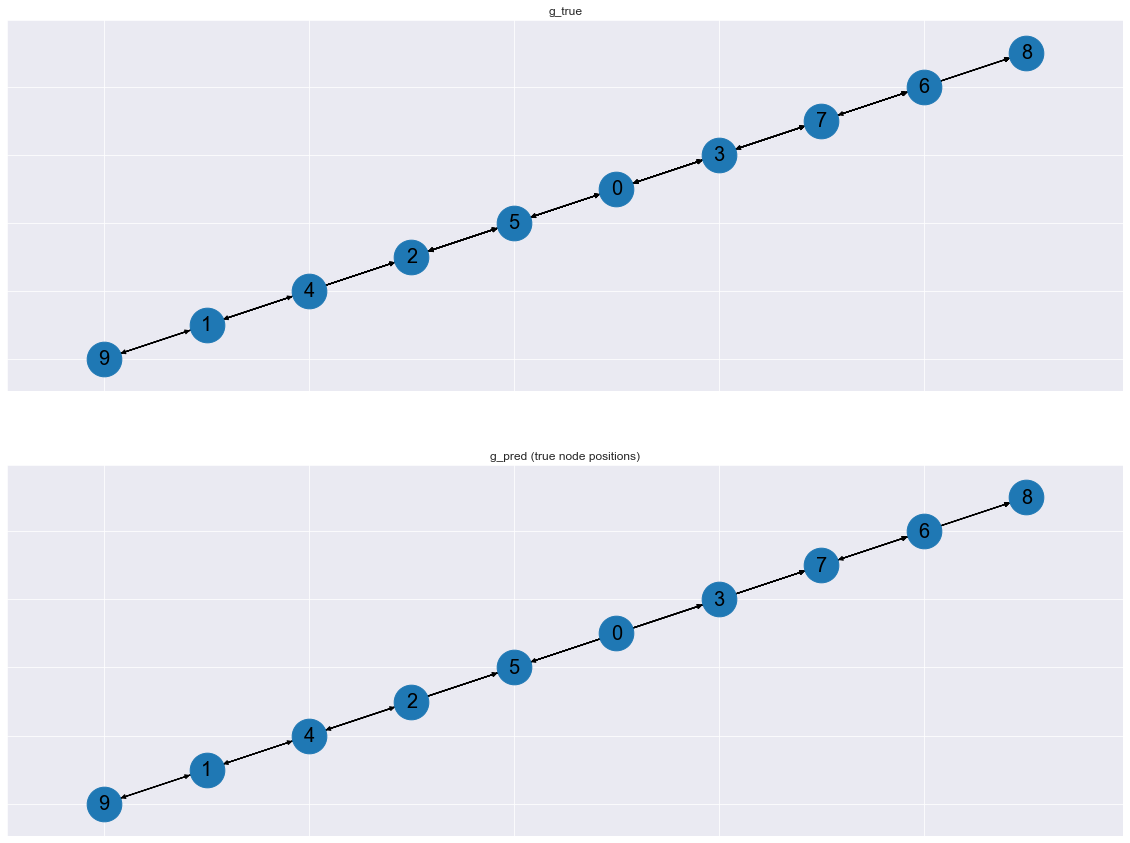

In [6]:
for key in LOGS:
    g_true, g_pred = get_graphs(key)
    draw_dags(key, g_true, g_pred, cpdags=True, pred_with_true_pos=True)
